In [3]:
import json
from PIL import Image
from tinyllava.model.load_model import load_pretrained_model
from tinyllava.data.text_preprocess import TextPreprocess
from tinyllava.data.image_preprocess import ImagePreprocess
from tinyllava.utils.constants import *
from tinyllava.utils.message import Message

# HuggingFace model path (https://huggingface.co/Yuki-Kokomi)
hf_path = 'Yuki-Kokomi/OpenECAD-SigLIP-2.4B'
# 모델, 토크나이저, 이미지처리, context length 불러오기
model, tokenizer, image_processor, context_len = load_pretrained_model(hf_path)
model.cuda()

# 텍스트, 이미지 전처리기 초기화
text_processor = TextPreprocess(tokenizer, 'gemma')
image_processor = ImagePreprocess(image_processor, model.config)


/home/jung/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 텍스트 데이터 파일 경로
text_path = 'dataset/text_files/data_3d_lite.json'
text_data = json.load(open(text_path))

data_id = text_data[0]['id']  # 데이터 ID
image_file = text_data[0]['image']  # 이미지 파일명
query = text_data[0]['conversations'][0]['value']  # 프롬프트
answer = text_data[0]['conversations'][1]['value']  # 정답 레이블

msg = Message()  # 메시지 객체 생성 (언어모델에 입력하기 위한 대화형 template을 만들어주는 역할)
msg.add_message(query)

result = text_processor(msg.messages, mode='eval')   # 토큰화
input_ids = result['input_ids'].unsqueeze(0).cuda()

print(input_ids.shape, image_file) 
print(query)
print(answer)

torch.Size([1, 66]) 00000131.jpg
<image>
This image is a view of a 3D model from a certain angle. Please try to use Python-style APIs to render this model.
Of course, here are the codes:
```python
SketchPlane0 = add_sketchplane(
	origin= [0., 0., 0.], normal= [1., 0., 0.], x_axis= [ 0.,  1., -0.], y_axis= [0., 0., 1.])
Loops0 = []
Curves0_0 = []
Circle0_0_0 = add_circle(center= [175.5, 128. ], radius= 47.5)
Curves0_0.append(Circle0_0_0)
Loop0_0 = add_loop(Curves0_0)
Loops0.append(Loop0_0)
Curves0_1 = []
Circle0_1_0 = add_circle(center= [175.5, 128. ], radius= 24.9375)
Curves0_1.append(Circle0_1_0)
Loop0_1 = add_loop(Curves0_1)
Loops0.append(Loop0_1)
Profile0 = add_profile(Loops0)
Sketch0 = add_sketch(sketch_plane= SketchPlane0, profile= Profile0,
	sketch_position= [-0.  , -0.75,  0.  ], sketch_size= 1.5)
Extrude0 = add_extrude(sketch= Sketch0,
	operation= 0, type= 0, extent_one= 0.2109, extent_two= 0.)
```


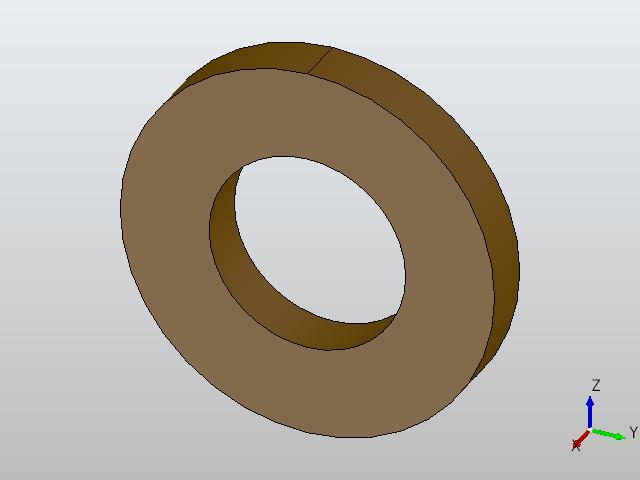

(torch.Size([1, 3, 384, 384]), [(640, 480)])

In [ ]:
# 이미지 파일 경로
image_path = f'dataset/openecad/images_3d/cad_image/{image_file}'
image = Image.open(image_path).convert('RGB')
display(image)  # Jupyter notebook에서 이미지 출력

image_tensor = image_processor(image)  # 이미지 전처리(텐서화)
image_tensors = image_tensor.unsqueeze(0).half().cuda()
image_sizes = [image.size]
image_tensors.shape, image_sizes

In [ ]:
temperature = 0.2   # temperature가 높으면 더 다양한 문장이 생성됨, 낮으면 더 일관된 문장이 생성됨
output_ids = model.generate(inputs=input_ids,  # input token
                            images=image_tensors,  # image tensor
                            image_sizes=image_sizes,   # image size
                            do_sample=True if temperature > 0 else False,  # 확률적 sampling 여부
                            temperature=temperature,  # temperature
                            max_new_tokens=context_len,  # context length
                            use_cache=True
)
outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)  # 출력된 토큰을 텍스트로 디코딩

In [ ]:
print(outputs[0])  # 터미널에 출력
print(outputs[0], file=open('output_example.md', 'w'))  # `output_example.md`라는 마크다운 파일에 출력

 Of course, here are the codes:
```python
SketchPlane0 = add_sketchplane(
	origin= [0., 0., 0.], normal= [1., 0., 0.], x_axis= [ 0.,  1., -0.], y_axis= [0., 0., 1.])
Loops0 = []
Curves0_0 = []
Circle0_0_0 = add_circle(center= [175.5, 128. ], radius= 47.5)
Curves0_0.append(Circle0_0_0)
Loop0_0 = add_loop(Curves0_0)
Loops0.append(Loop0_0)
Curves0_1 = []
Circle0_1_0 = add_circle(center= [175.5, 128. ], radius= 25.175)
Curves0_1.append(Circle0_1_0)
Loop0_1 = add_loop(Curves0_1)
Loops0.append(Loop0_1)
Profile0 = add_profile(Loops0)
Sketch0 = add_sketch(sketch_plane= SketchPlane0, profile= Profile0,
	sketch_position= [-0.  , -0.75,  0.  ], sketch_size= 1.5)
Extrude0 = add_extrude(sketch= Sketch0,
	operation= 0, type= 0, extent_one= 0.15, extent_two= 0.)
```


In [ ]:
from pythonocc_operator.py2step import show

# python code로 저장
py_path = 'output_example.py'
file = open(py_path, 'w')
for s in outputs[0].split('\n')[2:-1]:
    file.write(s+'\n')
file.close()

# OCC GUI로 출력 (window pop-up)
show(py_path)

NameError: name 'outputs' is not defined